OSE Scientific Computing | Winter 2021, M.Sc. in Economics, University of Bonn | [Sona Verdiyeva](https://github.com/s6soverd) and [Abraham Raju](https://github.com/Abraham-newbie)

# Prediction of Crime Rates using Brightness derived from Nighttime Satellite Light Images - VIIRS

This notebook contains derivation of brightness index from [VIIRS Nighttime Satellite Light Images](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG), and with the addition of other control variables, the prediction of crime rates in the city of Portland, Oregano state in US. As far as the brightness index concerns, the index is derived for all the neighborhoods in the city of Portland, for which the 'offense type and occurrence' datasets are available. 

### Table of Contents 
* [1.Overview](#overview) 
* [2.VIIRS - Nighttime Satellite Light Images](#viirs) 
* [3.On the derivation of Brightness Index](#derivation) 
    * [3.1. Example: Manual Derivation](#manuald)
    * [3.2. Unit Test on Brightness Index function](#unittest)
* [4. Preparation of the data for further analysis](#datawrangling)
* [5. Interactive Mapping: Crime Data and Brightness Values across Years](#mapping)
* [6. Random Forest Regression: Prediction of crime rate using Brightness Index](#rfc)
* [7.Conclusion](#conclusion)
* [8.References](#references)


In [1]:
#### All the neccessary Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame, Image
import datetime as dt
#import geemap, ee
#try:
        #ee.Initialize()
#except Exception as e:
        #ee.Authenticate()
        #ee.Initialize()

#! pip install openpyxl
#import geopandas
#import fiona
#import folium 
#import os
#from geopandas import GeoDataFrame


### Functions imported from the auxiliary file
import auxiliary.data_wrangling as dw
#import auxiliary.brightness as br
#import auxiliary.geo_converter as gc
#import auxiliary.maps as maps

## 1. Overview <a class="anchor" id="overview"></a>

Spatial Analysis of crime is the use of Geospatial Information to visualize the spatial data for explanatory statistical analysis and as well as with the purpose of identifying how certain factors (e.g, population characteristics, structural or ecological changes etc.) affect the spatial patterns of crime.  Crime mapping, hence, can be used for resource allocation and policy improvement purposes, so that the police force has a more centralized knowledge of the hotspots of different crime types across time and space and the concerns of the local populace are better addressed. <br>
In *'Crime Prediction & Monitoring Framework Based on Spatial Analysis'*, the authors put an emphasis on analysis of past crime data in helping to predict the crime rate, which could in turn, assist in reducing the crime rate(Hitesh Kumar Reddy et al., 2018). The underlying rationale is that crimes are predictable since the offenders operate under their comfort zones, and once a crime is committed, the same offense could be repeated under similar settings/circumstances.  And since there is a possibility of the same offense to happen again, this makes it easier to predict crime. The authors utilize K-Nearest neighbors and Naive Bayes algorithm and a dataset with latitude, longitude of a location where offence took place and the monthly frequency of the different types of offenses for the given row of latitude and longitude data. The past dataset is taken as a training dataset and the recent dataset is used as testset. If in the past a certain crime type occurred in a certain latitude-longitude point, K-NN calculates the Manhattan distance of trainset and testset geospatial datapoints, and the probability of this crime happening again, and the locations nearby the previous crime location is set to be more probable for the crime occurrence. <br>
In *'Crime Rate Inference with Big Data'*, the inference of crime rate at the neighborhood level is undertaken using not only geospatial and demographic data but also taxi flow data in the city of Chicago(Hongjian Wang, 2016). To do the inference, both linear and Poisson regression models are used, as in predicting the crime rate, there is no guarantee that the predicted crime rate would be non-integer, hence Poission model is also used for the same problem. <br>
A large number of studies suggest that there is a link between crime rate and the socioeconomic and demographic characteristics. In one study in Portland, it was established that how intensive the crime rate in surrounding areas is affects the level of crime in the bordering neighborhoods (Kadziolka, 2016). The spatial weight matrix was derived using the below formula, where $w_{ij} = 1$ if $i \neq j$,where area $i$ shares a common border with area $j$. Otherwise, $w_{ij} = 0$.
$$
w^{*}_{ij} = \frac{w_{ij}}{\sum\limits_{j} w_{ij}}
$$
Crime is a phenomenon that is associated with socioeconomic and psychological factors. But whether it is random across space and time, hinting at the unimportance of geography is the central topic of the *'Exploratory spatial analysis of crimes
against property in Turkey'*, and the conclusion that the authors have reached is that the property offenses are densely concentrated in the west and south-western parts of Turkey, meaning, crime is not random across time and space (S. Erdogan, 2012). <br>
This project focuses on the addition of brightness values derived from Nighttime Satellite Image Collection in predicting the number of crime occurrences that are more bound to happen during the night, and see whether the lights do hold a predictive power over crime occurrence or not. <br>
The structure of the notebook is as follows. The first section explains the VIIRS - Nighttime Satellite Light Images, followed by how the brightness values across time given an area of interest is derived. All the functions are placed in their corresponding files in auxiliary folder. Since Continuous Integration was failing in installing neccessary packages (geopandas, geemap, ee, os, folium, fiona), the certain functions are commented out; however, their outputs are saved. <br>
To run this notebook with uncommented functions, one could create a local environment by running the below commands in the command line of shell:
```python
! conda create --name geo
! conda activate geo
! conda install mamba –c conda –forge     #Instaling mamba, that makes the installation of ‘geemap’ package faster
! mamba install geemap –c conda –forge
! conda install –c anaconda ipykernel
! conda config --prepend channels conda-forge
! conda create -n geo --strict-channel-priority geopandas jupyterlab  #Installing geopandas on Windows
! python –m ipykernel install --user --name = geo   #This sets this conda environment on your jupyter notebook
```
The follow-up subsection displays an example derivation for a given latitude-longitude point, the output of which is plotted against time. The unit test is written for testing couple of features of the brightness function. <br>
In the subsequent section, the data is prepared for the further analysis, by concatenating the crime datasets across years and matching the names of neighborhoods inside crime dataset with those in brightness index dataframe. Since brightness index dataframe is based on a shapefile of neighborhoods and their corresponding geometry information and crime datasets are sourced from a different website, there were differences in how the names of the same neighborhood was written. After the names were matched, the datasets were merged and saved into three different files, whether the crime occurred during the daytime, or nighttime, or all day long. <br>
The interactive mapping section explores the geospatial analysis of crime patterns against the distribution of brightness and population by neighborhoods in Portland. <br>
The section on Random Forest Regression explores the predictive power of brightness values in predicting the crime occurrence number, and compares the accuracy metric of the model against that of the rudimentary baseline model.






## 2. VIIRS - Nighttime Satellite Light Images <a class="anchor" id="viirs"></a>

The first digital archive of nighttime lights taken by satellites established at the National Geophysical Data Center in 1992 contains nighttime data from two satelitte platforms - United States Air Force series of polar-orbiting Defense Meteorological Satellite Program-Operational Linescan System (DMSP-OLS) and the current NASA/NOAA SNPP satellite’s the Visible Infrared Imaging Radiometer Suite (VIIRS-DNB) (Xi Chen et al., 2019).  <br>
The first low-light imagery from DMSP dates back to 1960's, while the dataset availability for VIIRS-DNB covers the period from 2014-01-01 onwards. Some new features of VIIRS lights data have eliminated or reduced the limitations of DMSP-OLS sensor. In a nutshell, the main limitations of DMSP-OLS sensor are the following (Feng-Chi Hsu et al., 2015):
* Low radiometric resolution
* No on-board calibration
* Large spatial resolution
* Saturation in urban cores <br>

To process the satellite imagery, we will be using **Google Earth Engine (GEE)**, which is a cloud-based platform for planetary-scale geospatial analysis. It is open and free to the public. In addition, GEE provides access to multiple remotel-sensed datasets, including VIIRS-DNB. To pull VIIRS-DNB nighttime light images from GEE, the eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used. <br>
For interactive mapping with GEE, **geemap** -a python package - is used, as it is not part of the standard Python library, it should be seperately downloaded and installed. Geemap can be used to analyse and visualize datasets available in GEE. <br>
To work with satellite data that covers enormous area geospatially, one can work with smaller Area of Interest, that can be either a buffer zone around a latitude-longitude point or a geometry from geopolitical boundary; and then the entire image dataset is clipped into this smaller AOI. <br>
If one wants to focus on the geopolitical boundary of a country, then a **shapefile** of the country is used. Shapefile  is a digital vector storage format for storing the geographic location. Geographic features in a shapefile can be represented by points, lines, or polygons (areas).  <br>
To import shapefile with geemap, the **Coordinate Reference System (CRS)** of the shapefile should be EPSG:4326. CRS basically tells Python how the coordinates inside a shapefile relates to places on Earth. 

## 3.On the derivation of Brightness Index <a class="anchor" id="derivation"></a>

The function below is generic enough to work with VIIRS-DNB image collection for any time period available and for any AOI (either buffer zone or shapefile). The daily images in VIIRS-DNB are aggregated into **monthly composites**, so given a point on Earth and a year, there are only 12 images in the collection. 

Since we are going to work with shapefile of the city, we need to provide the path to the shapefile, rather than the shapefile itself. Because to import the shapefile with geemap, a path to your shapefile should be given. And the directory in which your .shp (shapefile) is located should also include .dbf, .cpg, .prj, .shx extension files that comes with a usual shapefile folder. <br>
To read the content of the shapefile, **geemap** package is being used, which only accepts the shapefile with the CRS format being equal to **"EPSG:4326"**.  The brightness.py file inside auxiliary folder comes with a function to identify the crs of the shapefile. Unless the CRS of a shapefile is equal to **"EPSG:4326"**, the brightness function will set the CRS to the accepted format. <br>
To get to know how to use the brightness function and access the explanation of the arguments used, one can use the function below to access the docstrings:

In [2]:
def explanation(function):
    return print(function.__doc__)
#explanation(function = br.brightness)

**Step 1:** <br>
Extracting the image collection for the years specified and the given band from the VIIRS-DNB Nighttime satellite light images, we use **ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(date_from, date_to).select(band)** Earth Engine snippet. VIIRS Image Collection is available overall for the years: 2014-01-01 - 2021-05-01. **NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG** is simply the complete dataset. For the Dataset - VIIRS Stray-light Corrected Day/Night Band composites, there are two bands available: 
* avg_rad(=Average DNB radiance values.) 
* cf_cvg (=Cloud-free coverages, This band can be used to identify areas with low numbers of observations 
     where the quality is reduced.) 

**Step 2:** <br>
First we need to create a list of feautures for all areas of interest in the form of **ee.Feature(ee.Geometry.Point(latitude, longitude).buffer(km), dict)** if buffer zone and latitute and longitude points are provided; or **ee.Feature(imported_shapefile.geometry(), dict)** if the shapefile is being fed into the function. Here, 'geometry' is the column with the geospatial data, since the usual shapefiles come with the geospatial data being stored in the 'geometry' column.  <br>
Specifically, a Feature is an object with a geometry property storing a Geometry object (or null) and a properties property storing a dictionary of other properties.

**Step 3:** <br>
Given the list of features, we are going to create a Feature Collection for our areas of interest using **ee.FeautureCollection(features)**.

**Step 4:** <br>
The function to reduce our collection of geometries to a single parameter, in our case, to the arithmetic mean of its inputs (pixel values) per a monthly aggregate satellite image and also another function to get the individual image dates. And we map these functions to our image collection.

**Step 5:** <br>
We create a reducer that collects its inputs into a list, using earth engine objects for mean values from images and the dates. 

In [2]:
### Below, we will first dentify the crs of the shapefile, and derive the the brightness index for the shapefile of Portland

#path_to_my_shapefile = r".\Shapefile_Portland\Neighborhood_Boundaries.shp"
#crs_portland_shp = br.identify_crs(pathtomyshapefile = path_to_my_shapefile)
#brightness_index = br.brightness(date_from = "2015-07-01", date_to = "2021-05-31", 
                           #  buffer_df = None, buffer_dist = None, band = "avg_rad", aoi_type = "shapefile", 
                           #  crs = crs_portland_shp.upper(), pathtomyshapefile = path_to_my_shapefile,
                           #  shp_column_name = "NAME")
#brightness_index.to_csv("data/brightness_index.csv")
brightness_index = pd.read_csv("data/brightness_index.csv")

### 3.2. Example: Manual Derivation <a class="anchor" id="manuald"></a>

Let's do a simple derivation of brightness index for a latitude and longitude point of Ganja, a city in the northwest of Azerbaijan, for the Jan 2015 to April 2021, and plot the values across dates "2015-01-01" to '2021-04-01'. <br>
**Step 1:** <br>
Given the fact that VIIRS-DNB Image Collection has only one image per month, we need to have two seperate lists of dates in date format; in one list, the first days of the months from 2015 January till April 2021 are included, and in the other, the last days of the month, using [pd.date_range](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html) function and [datetime.date](https://docs.python.org/3/library/datetime.html) module in python. <br>
**Step 2:** <br>
The eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used for the dates Jan 2015 to April 2021. <br>
And the whole image collection for each month seperately is being then clipped into the area of interest being demarcated by **ee.Geometry.Point([lon, lat]).buffer(km)** function. <br>
**Step 3:** <br>
The area of interest is then being reduced to the average brightness value per month for the pixels in Ganja, using [image.reduceRegion(reducer, scale)](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion) function. <br>
**Step 4:** <br>
Lastly, we cast the derived value to  [ee.Number(numeric_object).getInfo()](https://developers.google.com/earth-engine/apidocs/ee-number-getinfo) and get the number of the computed object.

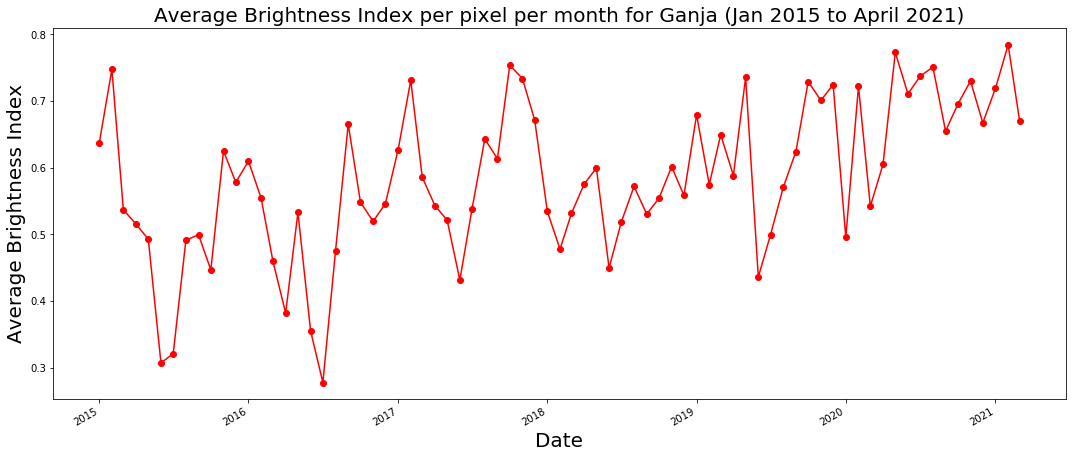

In [4]:
#ganja = br.ganja_brightness(date_from = '2015-01-01', date_to = '2021-04-01', 
                           # ganja_lat = 40.6879, ganja_lon = 46.3723, buffer_distance = 50000)
#ganja.to_csv("data/ganja_brightness.csv")
ganja = pd.read_csv("data/ganja_brightness.csv")
first_day_of_month= pd.date_range('2015-01-01', '2021-04-01', freq='1M') - pd.offsets.MonthBegin(1)
df_date_first_days = pd.DataFrame(data = first_day_of_month, columns = ["first_day_dates"])
f = df_date_first_days["first_day_dates"].dt.date
fig, ax = plt.subplots(figsize=(15,7))
plt.plot_date(f, ganja["ganja_brightness"], linestyle = 'solid', color = 'r')
ax.set_ylabel('Average Brightness Index',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Average Brightness Index per pixel per month for Ganja (Jan 2015 to April 2021)',fontsize=20)
plt.tight_layout()
plt.gcf().autofmt_xdate()

### 3.2. Unit Test on Brightness Index function <a class="anchor" id="unittest"></a>

A **Unit Test** is a small test that checks at a time whether a single component in an application/function/etc. works in the expected way. There are many test runners in Python, the one that is built into standard Python library is called **unittest**, which you need to simply import, for it to run the test. To write and execute your test in unittest, there are some requirements:
* ```Python
import unittest
```
* Put your tests into classes as methods, for that one needs to create a subclass, that inherits from unittest TestCase class
* Add *self* as the first and only argument for test functions
* Instead of built-in assert statement, use self.assertEqual(), self.assertIs(), self.assertTrue(), self.assertIn(),etc. methods of the TestCase Class. 
* To run the test in shell, there are different command line entries; e.g., <br>

This one executes your test file:
```Python
python <'the name of the test file goes here'> 
```

This one executes your test file and -v (verbose) option lists the names of the functions and the result of each:
```Python
python -m unittest -v <'the name of the test file goes here'>
```  

In [54]:
# ! python -m unittest -v test_brightness

## 4. Preparation of the data for further analysis <a class="anchor" id="datawrangling"></a>

Below, we are going to concat the crime data from 2015 to 2021 and match the names of the neighborhoods in Portland with the names of places in the shapefile for the brightness index. As it is a crime data for all the crime types that happened all day long, given the occurrence time, we divided the data for the crimes that happened during the day, night or all day long. For the prediction of the crime rate using brightness index, the crimes that occurred during the nighttime are relevant. 

In [3]:
# Crime Data for the years 2015 - 2021
df_matched1 = pd.read_csv("Crime_Data/CrimeData-2021.csv")
df_matched2 = pd.read_csv("Crime_Data/CrimeData-2020.csv")
df_matched3 = pd.read_csv("Crime_Data/CrimeData-2019.csv")
df_matched4 = pd.read_csv("Crime_Data/CrimeData-2018.csv")
df_matched5 = pd.read_csv("Crime_Data/CrimeData-2017.csv")
df_matched6 = pd.read_csv("Crime_Data/CrimeData-2016.csv")
df_matched7 = pd.read_csv("Crime_Data/CrimeData-2015.csv")

# Concat them all
dataframes = [df_matched1, df_matched2, df_matched3, df_matched4, df_matched5, df_matched6, df_matched7]
df_concatted = dw.drop_nan_and_uncommon_and_concat(dataframes = dataframes)

# Match and merge with brightness_index - for the Offenses that occurred in the night/ daytime/or both
df_matched = dw.matching_names(df1 = df_concatted, 
                               df2 = brightness_index, 
                               c1 = "Neighborhood", 
                               c2 = "Names of Places")
df_merged = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "night")
df_with_controls = dw.add_controls(df_merged = df_merged)

# Saving also the crime data with controls for daytime and for all daylong occurence
df_merged_day = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "day")
df_with_controls_day = dw.add_controls(df_merged = df_merged_day)

df_merged_all = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "all")
df_with_controls_all = dw.add_controls(df_merged = df_merged_all)


df_with_controls_day.to_csv("data/df_with_controls_daytime.csv")
df_with_controls_all.to_csv("data/df_with_controls_alldaylong.csv")
df_with_controls.to_csv("data/df_with_controls_nighttime.csv")

## 5. Interactive Mapping: Crime Data and Brightness Values across Years <a class="anchor" id="mapping"></a>

To generate interactive maps, a dataset should be extended with a geospatial data.

In [7]:
# Data Loading - shapefile of Neighborhoods in Portland in .csv format
shapefile_portland = pd.read_csv("shapefile_dataframe_format.csv")

### Exploratory Data Analysis
**1.** Bar Chart to visualize the population density data of Portland by neighborhood.

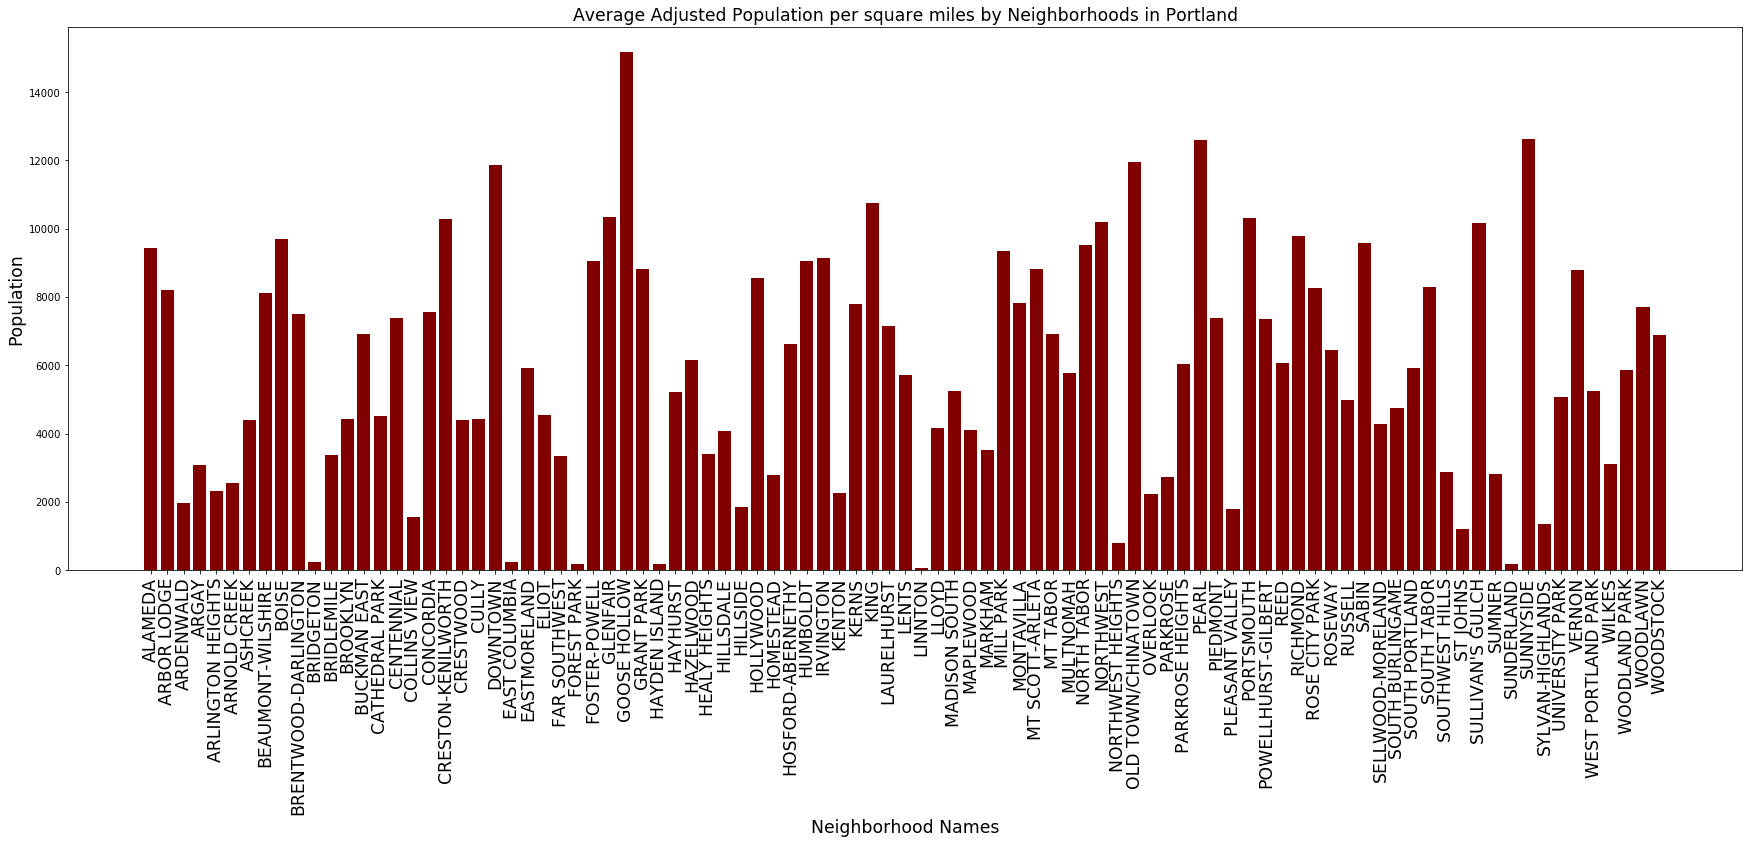

In [8]:
# Create a new column - Year
df_with_controls["Year"] = df_with_controls.OccurMonth_Year.astype(str).str[:-3]
# Group by the dataset by Neighborhood and Year, and average the population for the years 2015 to 2021 by Neighborhood
average_adj_pop_by_neighborhood = df_with_controls.groupby(["Neighborhood", "Year"])['adj_popn_pe_sq_mi'].mean().reset_index()

# Create the figure
fig = plt.figure(figsize = (30, 10))
x = average_adj_pop_by_neighborhood[average_adj_pop_by_neighborhood["Year"] == "2015"]["Neighborhood"]
y = average_adj_pop_by_neighborhood[average_adj_pop_by_neighborhood["Year"] == "2015"]['adj_popn_pe_sq_mi']
 
# creating the bar plot
plt.bar(x, y, color ='maroon')
 
plt.xlabel("Neighborhood Names", fontsize = "xx-large")
plt.ylabel("Population", fontsize = "xx-large")
plt.title("Average Adjusted Population per square miles by Neighborhoods in Portland", fontsize = "xx-large")
plt.xticks(rotation = 90, fontsize = "xx-large")
plt.show()

###  Choropleth Map using Shapefile
Let's now visualize choropleth maps for population density, crime data and brightness.

In [8]:
# Bringing the names of places in shapefile to the form that is used in crime dataset
list_names = []
for name in shapefile_portland["NAME"]:
    n = name.replace(" ", "_").replace("/", "_").replace(".", "").replace(",", "_")
    list_names.append(n)

# Creating a column to include the updated Names
shapefile_portland["Matched_Names"] = list_names

# Slicing the shapefile_portland dataframe to only include the Names and Geometry of the areas
sliced_shapefile = shapefile_portland[["Matched_Names", "geometry"]].dropna()

**1. Visualizing the population density:**

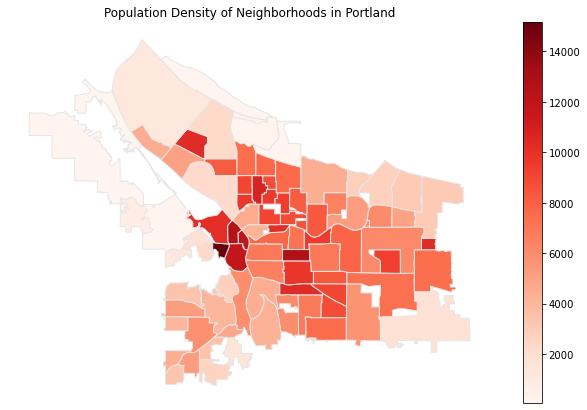

In [9]:
#maps.choropleth_by_pop(df_pop= df_with_controls, df_shapefile = sliced_shapefile, by = "interactive")
Image(filename='Figures/pop_density_static.png') 

From the static choropleth map above, it is apparent that the highest density of the population is spread across center and the south-eastern parts of the Portland. Let's see below, how the brightnes and the offense rate per $100000$ are spread and whether just by looking at the map, one could derive an apparent insight among them or not.

**2. Mapping By Brightness Index and year:**

In [10]:
# Generate annual average of brightness index by Neighborhoods in Portland
brightness_index["Year"] = brightness_index.dates.astype(str).str[:4]
brightness_annual_ave = brightness_index.groupby(["Names of Places",
                                                  "Year"])["Average Radiance Per Pixel Per month"].mean().reset_index()

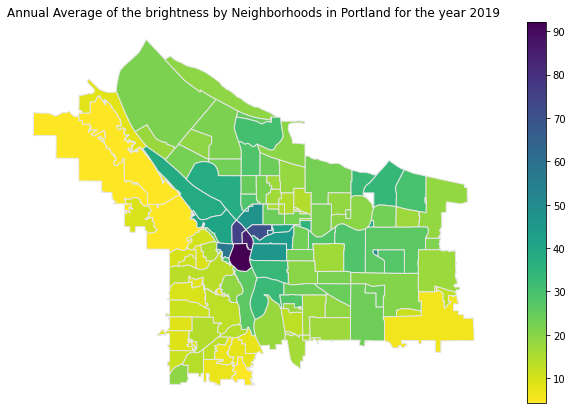

In [11]:
#maps.choropleth_by_brightness(df = brightness_annual_ave, shapefile = sliced_shapefile, 
                              #year = "2019", by = "static")
year = "2019"
Image(filename=f'Figures/Brightness_static{year}.png')

As it appears, the brightness values are higher in places where population is highly concentrated; mainly in the center and south-and-north-eastern parts of the map; which is to be expected.

**3. By Crime Rate and Year:**

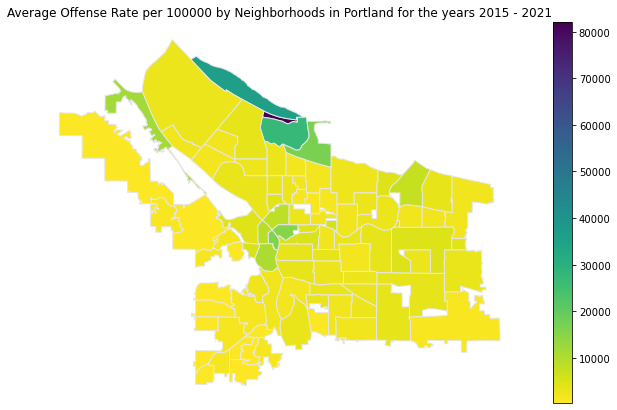

In [12]:
#maps.choropleth_by_crime(merged_df = df_with_controls, shapefile = sliced_shapefile,
                        #year = None, by = "interactive", type = "average")
Image(filename='Figures/AveCrimeRateper100k_static.png')   

The Offense rate per $100000$ is derived by summing up all types of offenses happened in a certain year and then dividing that value by the adjusted population number, which is then multiplied by $100000$ to get the rate. <br>
In the function, one has the option to set the aargument calle 'type' to average or yearly. If average is being chosen, as above,  average value for the offense rate per 100k across years is fed into the map. <br>
The average offense rate per 100k is high on the far north-west of the Portland, and it is distributed evenly low to other parts of the city. 


## 6. Random Forest Regression: Prediction of crime rate  using Brightness Index <a class="anchor" id="rfc"></a>

**Random Forest** is a Machine Learning algorithm that can perform both classification and regression problems with the help of a technique called **bagging**; the idea behind which is to combine the outputs of multiple decision trees and determine the end output. <br>
The problem we will tackle is the prediction of crime rate using brightness index, given 5 years of past crime and brightness data. This kind of prediction is a supervised regression problem. It is supervised because we do have an access to the past data for both predictor and predicted variables. It is regression-based, since the variable we want to predict is continuous. 

**1st Step: Import the required libraries**

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

**2nd Step: Prepare the data**

The offenses that are relevant for a prediction model using brightness index are 'Robbery', 'Prostitution Offenses', 'Larceny Offenses' and 'Sex Offenses'. So the label that we are going to predict will be the sum of the occurrence number per month for the above mentioned crimes in a neighborhood. The dataset is restricted to those neighborhoods for which there are entries ($0$ is also considered to be an observation) for each month across July, 2015 till 2021. 

In [10]:
# Read the data
df_rf = df_with_controls[['OccurMonth_Year', 'Matched_Names', 'Larceny Offenses', 'Prostitution Offenses', 'Robbery',
                          'Sex Offenses', 'Average Radiance Per Pixel Per month']]                       

# Drop the rows with missing values
df_rf.dropna(inplace = True)
# Year and Month column being set as datetime
df_rf['OccurMonth_Year'] = pd.to_datetime(df_rf['OccurMonth_Year'], errors='coerce')
df_rf["Year"] = df_rf['OccurMonth_Year'].dt.year
df_rf["Month"] = df_rf['OccurMonth_Year'].dt.month
# neighborhoods having entries for each month from July, 2015 till 2021
names = []
for n in list(df_rf['Matched_Names'].unique()):
    if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2015)]) == 6:
        if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2016)]) == 12:
            if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2017)]) == 12:
                if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2018)]) == 12:
                    if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2019)]) == 12:
                        if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2020)]) == 12:
                            names.append(n)


df_rf = df_rf[df_rf['Matched_Names'].isin(names)]

# Summing up the occurrence number for the relevant offenses
df_rf["Offenses_Relevant"] = df_rf[['Prostitution Offenses', 'Robbery',
                                   'Sex Offenses', 'Larceny Offenses']].sum(axis = 1)

df_rf.drop(columns = ['Prostitution Offenses', 'Robbery', 'Sex Offenses', 'Larceny Offenses', 
                      'OccurMonth_Year'], inplace = True)

For the ML model to understand the data, the names of neighborhoods inside "Neighborhood" column are converted to numerical representation; this is called 'one-hot encoding' of the data. 

In [12]:
# One-hot encoding the data in Matched_Names Column
df_rf_encoded = pd.get_dummies(df_rf)
df_rf_encoded.head()

,Average Radiance Per Pixel Per month,Year,Month,Offenses_Relevant,Matched_Names_ALAMEDA,Matched_Names_ARBOR_LODGE,Matched_Names_ARGAY_TERRACE,Matched_Names_BEAUMONT-WILSHIRE,Matched_Names_BOISE,Matched_Names_BRENTWOOD-DARLINGTON,...,Matched_Names_SULLIVAN'S_GULCH,Matched_Names_SUMNER_ASSOCIATION_OF_NEIGHBORS,Matched_Names_SUNDERLAND_ASSOCIATION_OF_NEIGHBORS,Matched_Names_SUNNYSIDE,Matched_Names_UNIVERSITY_PARK,Matched_Names_VERNON,Matched_Names_WEST_PORTLAND_PARK,Matched_Names_WILKES_COMMUNITY_GROUP,Matched_Names_WOODLAWN,Matched_Names_WOODSTOCK
0,15.004552,2015,7,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15.694406,2015,8,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.273379,2015,9,5.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13.110718,2015,10,5.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12.334072,2015,11,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**3rd Step: Train-Test Split**

We will convert the pandas object to numpy arrays as the algorithm arguments require them to be in array data type. To split the data into train and test set so as to evaluate the ML model against a baseline model, I splitted the entries from 2015 to 2019 into train set, and entries from 2020 into test set. The label to predict is "Offenses_Relevant" column. And the features that predict it are Averange Randiance values, Year, Month and the categorical variable - "Matched_Names".

In [13]:
train_features = np.array(df_rf_encoded[df_rf_encoded["Year"].isin([2015, 2016, 2017, 
                                                                    2018, 2019])].drop("Offenses_Relevant", axis = 1))

train_label = np.array(df_rf_encoded.loc[df_rf_encoded["Year"].isin([2015, 2016, 2017, 2018, 2019]), "Offenses_Relevant"])
test_features = np.array(df_rf_encoded[df_rf_encoded["Year"] == 2020].drop("Offenses_Relevant", axis = 1))
test_label = np.array(df_rf_encoded.loc[df_rf_encoded["Year"] == 2020, "Offenses_Relevant"])


In [352]:
#train_predictors, test_predictors, train_predicted, test_predicted = train_test_split(predictors, to_be_predicted, 
                                                                                #test_size = 0.75, 
                                                                                #random_state = 30)

**4th Step: Train our model**

We will initialize the model with 1000 decision trees and train the model on our train set.

In [544]:
#random_forest_model = RandomForestRegressor(n_estimators = 1000, random_state = 30)
random_forest_model = RandomForestRegressor()
random_forest_model.fit(train_features, train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

**5th Step: Establish the Baseline model**

A basline model uses simple summary statistics to create predictions for the dataset. This metric will be the one we will compare against the Random Forest algorithm. The chosen baseline model is to use past 5 years data and average it for a rough prediction in 2020. Meaning, if for the neighborhood Alameda in Portland, in the past 5 years, for the month, say, January, the average value for the relevant offenses is 5 so that would be the rough guess of the baseline model for the prediction in, say, January 2020. <br>
The baseline error will be calculated using the absolute value of the difference between **"baseline predictions"** and the test dataset label values, which are essentially the number of offenses relevant for the year 2020.


In [542]:
# The Baseline Model
baseline_predictions = df_rf[df_rf["Year"].isin([2015, 2016, 
                                                2017, 2018, 
                                                2019])].groupby(["Month",
                                                                "Matched_Names"])["Offenses_Relevant"].mean().reset_index()

# Mean Baseline Error
baseline_errors = abs(baseline_predictions["Offenses_Relevant"] - test_label)
print('Mean baseline error: ', round(np.mean(baseline_errors), 2))

Mean baseline error:  8.7


**6th Step: Make predictions on the test set using the trained RF model and Evaluate the metric - Mean Absolute Error**

For evaluating the performance of the algorithm, Mean Absolute Error is chosen, instead of commonly used accuracy percentage, which is easier to interpret. The reason being is that in order to compute the accuracy percentage, one needs to divide the errors by the test labels. This means that there should be no zero observation in the dataset, otherwise, due to the division by zero error , it distorts getting meaningful accuracy percentage.

In [543]:
# Using the trained model on the test data
predictions_rf = random_forest_model.predict(test_features)
# Compute the Mean Absolute Error 
errors_rf = abs(predictions_rf - test_label)
print('Mean Absolute Error is:', round(np.mean(errors_rf), 4))

Mean Absolute Error is: 3.7025


Our Random Forest Model beats the simple baseline Model, since $Mean Absolute Error = 3.7 > Mean Baseline Error = 8.7$.
When the dataset is cleaned of the observations for the Offenses_Relevant being zero and accuracy is calculated, accuracy equals to around 40-50%, which is rather low. However, this is expected, given the limitations of the dataset and the fact that the number of offenses are tried to be predicted using only brightness index.

## 7. Conclusion <a class="anchor" id="conclusion"></a>

## 8. References <a class="anchor" id="references"></a>

1. The World Bank. [Open Night Lights](https://github.com/worldbank/OpenNightLights): Collection of tools and training materials for exploring the open Nighttime Lights repository. <br>
2. Hitesh Kumar Reddy ToppiReddy, Bhavna Saini, Ginika Mahajan. (2018). Crime Prediction & Monitoring Framework Based on Spatial Analysis. *Procedia Computer Science*, 132, 696-705. <br>
3. Hongjian Wang, Daniel Kifer, Corina Graif, Zhenhui Li. (2016). Crime Rate Inference with Big Data. *KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*,  635–644. <br>
4. Kadziolka Kinga. (2016). Analysis of the Crime rate in Poland in Spatial and Temporal Terms. *Central and Eastern European Journal of Management and Economics (CEEJME)*, 1, 81-96. <br>
5. Saffet Erdogan, Mustafa Yalcin, Mehmet Ali Dereli. (2013). Exploratory spatial analysis of crimes against property in Turkey. *Crime Law and Social Change*, 59, 63–78. <br>
6. Xi Chen, William D. Nordhaus. (2019). VIIRS Nighttime Lights in the Estimation of Cross-Sectional and Time-Series GDP. *Remote Sensing*, 1-11. <br>
7. Feng-Chi Hsu, Kimberly E. Baugh, Tilottama Ghosh, Mikhail Zhizhin, Christopher D. Elvidge. (2015). DMSP-OLS Radiance Calibrated Nighttime Lights Time Series with Intercalibration. *Remote Sensing*, 2, 1855-1876.




---

Notebook by Sona Verdiyeva and Abraham Raju | Find us on GitHub at https://github.com/s6soverd and https://github.com/Abraham-newbie

---